# Comparison of MLP and CNN on SVHN dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

import utils
from MLP_model import MLP
from CNN_models import CNN

%load_ext autoreload
%autoreload 2

In [2]:
max_epoch = 40
scenarios = []

In [3]:
utils.set_random_seed(42)

In [4]:
dataset = dsets.SVHN(root='data/', download=True, transform=transforms.ToTensor())
testset = dsets.SVHN(root='data/', download=True, split="test", transform=transforms.ToTensor())

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [5]:
# We use about 20% of the dataset for validation.
val_size = 10000
train_size = len(dataset) - val_size
batch_size = 128

print("Single Sample Shape: ", dataset[0][0].size())

trainset, valset = random_split(dataset, [train_size, val_size])
print("Data sizes after random splitting -> \nTrain data size = {} \nValidation data size = {} \nTest data size = {}".format(len(trainset),len(valset), len(testset)))

train_loader = DataLoader(trainset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(valset, batch_size)
test_loader = DataLoader(testset, batch_size)

print("Total number of batches in one epoch (Train):", len(train_loader))
print("Total number of batches in one epoch (Validation):", len(val_loader))
print("Total number of batches in one epoch (Test):", len(test_loader))

Single Sample Shape:  torch.Size([3, 32, 32])
Data sizes after random splitting -> 
Train data size = 63257 
Validation data size = 10000 
Test data size = 26032
Total number of batches in one epoch (Train): 495
Total number of batches in one epoch (Validation): 79
Total number of batches in one epoch (Test): 204


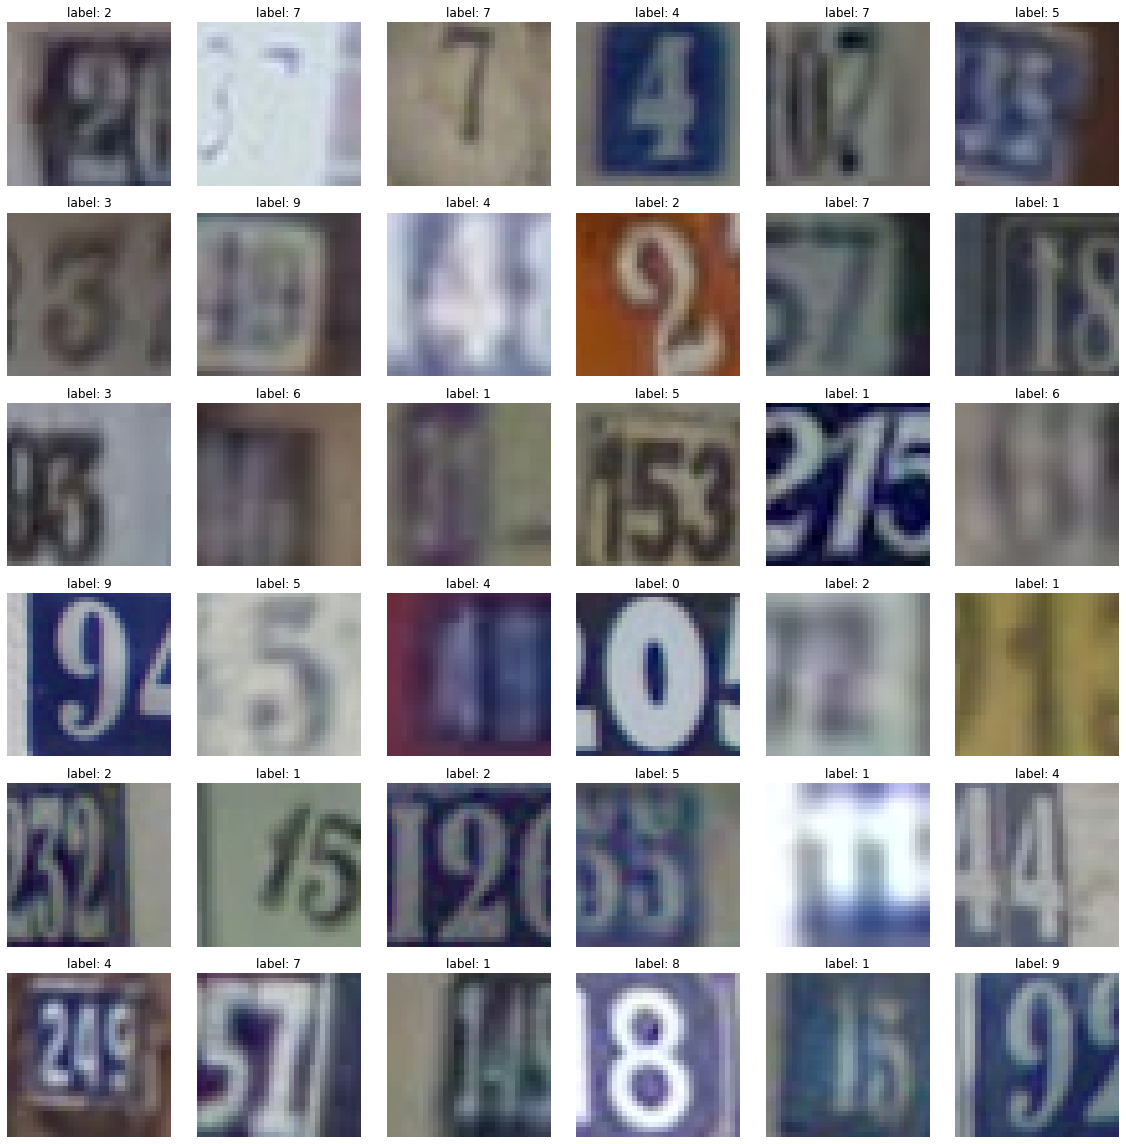

In [6]:
utils.visualize_data(trainset)

In [7]:
!nvidia-smi

Mon Nov 22 03:00:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8    19W /  N/A |   3489MiB / 16102MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Device is : cuda


## Training MLP

epoch 39 train acc: 0.7639 val acc: 0.7559 train loss: 0.8061 val loss: 0.8495: 


Time:  161.7386790360033
Test Loss : 0.9532021021141726 Test Acc: 0.722796670751634


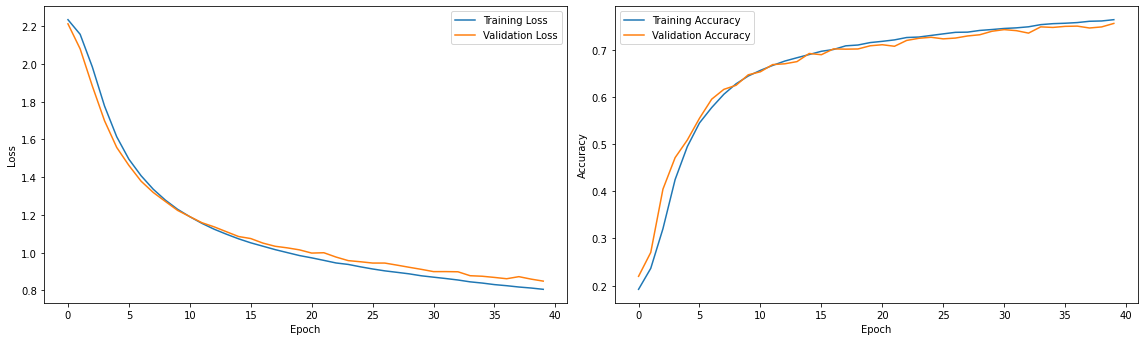

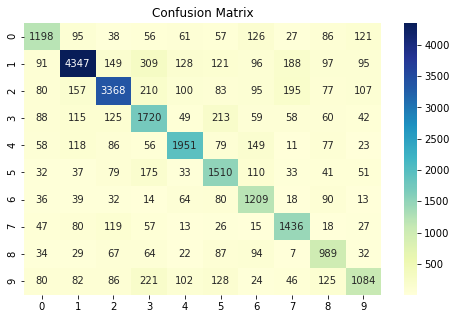

In [9]:
model = MLP(input_dim=np.prod(dataset[0][0].shape), hidden_dim=256, out_dim=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()
reg_params = None

train_loss, train_acc, val_loss, val_acc = utils.train(model, 
                                                 train_loader, 
                                                 val_loader, 
                                                 optimizer, 
                                                 loss_function, 
                                                 reg_function=None,
                                                 reg_params=reg_params,
                                                 max_epoch=max_epoch,
                                                 device=device)

test_loss, test_acc, confusion_matrix = utils.evaluate(model, test_loader, loss_function, device=device)
print("Test Loss : {} Test Acc: {}".format(test_loss, test_acc))

utils.visualize_loss_acc(train_loss, val_loss, train_acc, val_acc)
utils.visualize_confusion_matrix(confusion_matrix)

scenarios.append(("MLP - No Reg", train_loss, train_acc, val_loss, val_acc, test_loss, test_acc))

## Training basic CNN

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=800, out_features=10, bias=True)
)


epoch 39 train acc: 0.8764 val acc: 0.8667 train loss: 0.4563 val loss: 0.4945: 


Time:  194.6537192800024
Test Loss : 0.5432889803367502 Test Acc: 0.859592013888889


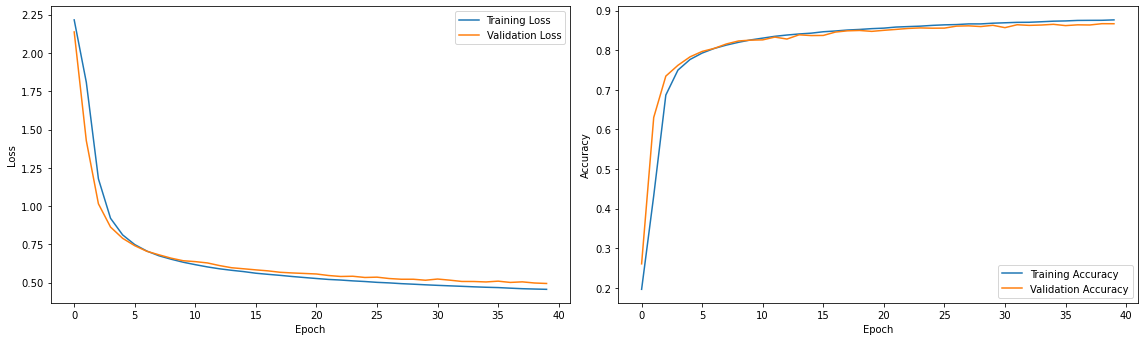

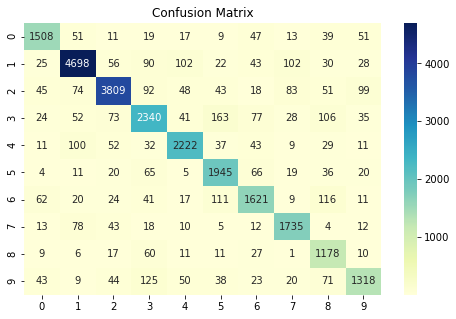

In [12]:
model = CNN().to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = torch.nn.CrossEntropyLoss()
reg_params = None

train_loss, train_acc, val_loss, val_acc = utils.train(model, 
                                                 train_loader, 
                                                 val_loader, 
                                                 optimizer, 
                                                 loss_function, 
                                                 reg_function=None,
                                                 reg_params=reg_params,
                                                 max_epoch=max_epoch,
                                                 device=device)

test_loss, test_acc, confusion_matrix = utils.evaluate(model, test_loader, loss_function, device=device)
print("Test Loss : {} Test Acc: {}".format(test_loss, test_acc))

utils.visualize_loss_acc(train_loss, val_loss, train_acc, val_acc)
utils.visualize_confusion_matrix(confusion_matrix)

scenarios.append(("CNN - No Reg", train_loss, train_acc, val_loss, val_acc, test_loss, test_acc))

## Plot & Compare All Scenarios

MLP - No Reg Test Accuracy: 0.723
CNN - No Reg Test Accuracy: 0.86


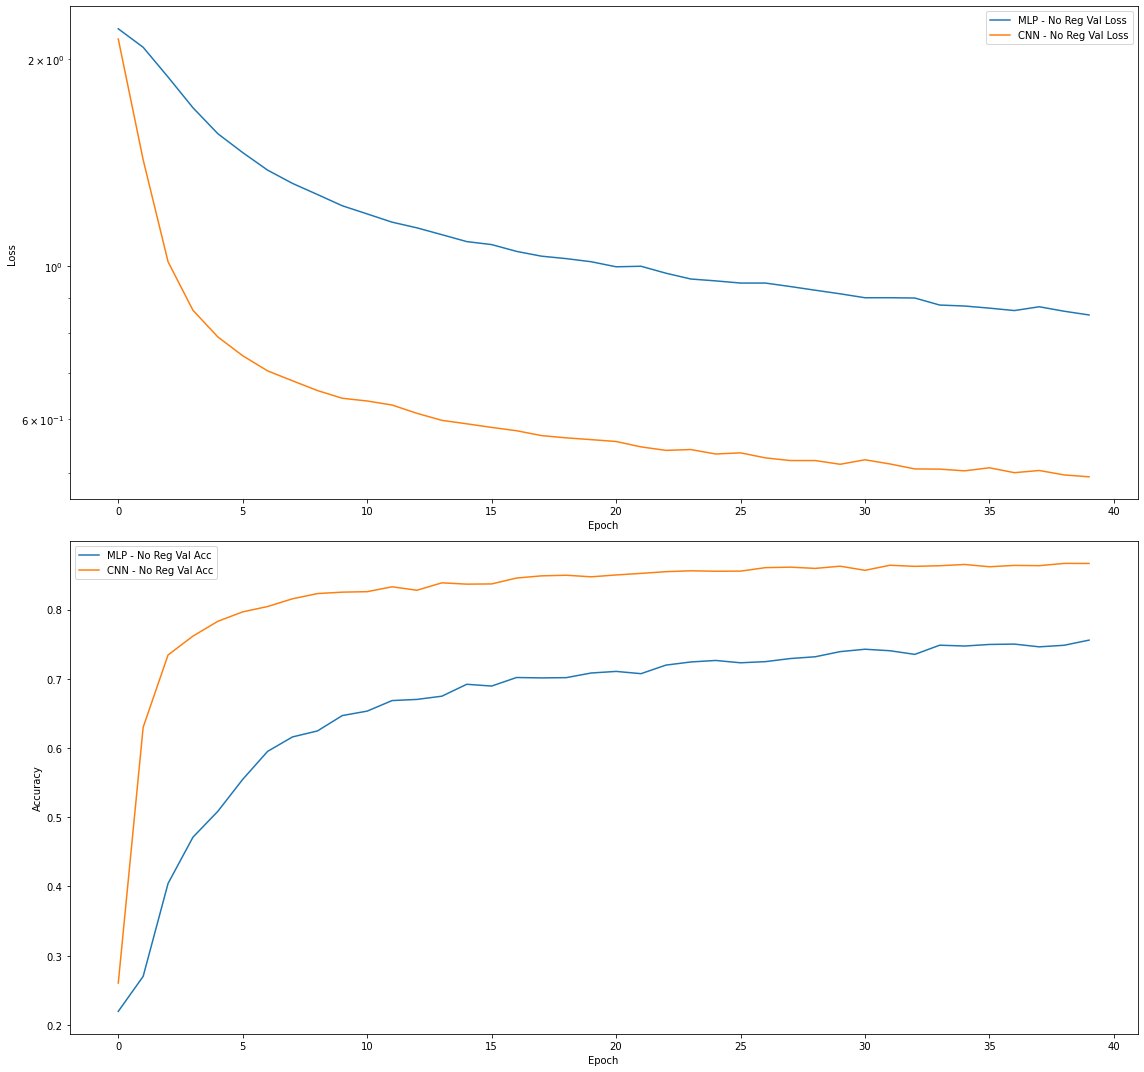

In [14]:
utils.plot_all(scenarios)

In [15]:
pickle.dump(scenarios, open( "CNNvsMLPscenarios.p", "wb" ) )